To process the data of mask:
`gs_calibration_v20240507.dxf`


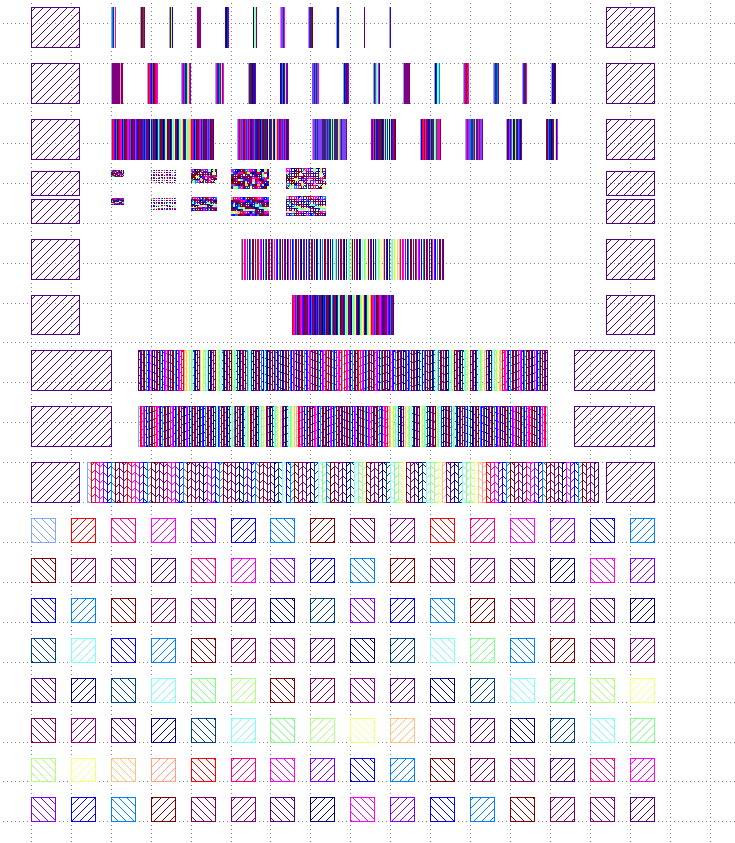

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.signal import find_peaks
import numpy as np
from scipy.interpolate import interp1d
import glob


In [2]:

def remove_duplicates(x, y):
    # Combine x and y arrays into a single 2D array
    data = np.column_stack((x, y))
    
    # Sort the data array based on the first column (x values)
    sorted_data = data[data[:,0].argsort()]
    
    # Find unique rows based on the first column (x values)
    unique_data = np.unique(sorted_data[:,0], axis=0, return_index=True)
    
    # Extract the unique x and y values
    unique_x = sorted_data[unique_data[1], 0]
    unique_y = sorted_data[unique_data[1], 1]
    
    return unique_x, unique_y

def parse_profilometer_xy_data(filename):
    
    

    df_header = pd.read_csv(filename, sep='\s+',header=None, nrows=7 )
    df_header = df_header.T
    df_header.columns = df_header.iloc[0]
    df_header = df_header.reindex(df_header.index.drop(0))
    name = df_header.Data
    x_resolution = df_header['X-Resolution'].astype('float').values
    y_resolution = 0.0001
    x_coord = df_header['X-Coord'].values
    y_coord = df_header['Y-Coord'].values
    
    # Data points
    df = pd.read_csv(filename, sep='\s+',header=0, skiprows=7)

    x = np.arange(len(df.Intermediate))*x_resolution
#     print(x)
    y = df['Normal']*y_resolution
#     plt.plot(x, y, label=file_i)

    return x,y


def get_profile_pyramid(filename, 
                            ramp_decreasing=True,
                            distance_between_fiducial_centroids=680, 
                            stylus_tip_offset=2,
                            greylevels=128, 
                            greyscale_step_width=2,
                            DEBUG_PLOTS=False):
    distance_pyramid_halfwidth = greyscale_step_width*greylevels

    x,y = parse_profilometer_xy_data(filename)


    ygrad = np.gradient(y,x)

    peaks, _ = find_peaks(ygrad, prominence=0.5)
    valleys, _ = find_peaks(-ygrad, prominence=0.5)

    # check if the peaks and valleys are correct
    if DEBUG_PLOTS:
        plt.plot(x, y)
        plt.plot(x, ygrad)
        plt.plot(x[peaks], ygrad[peaks], "x")
        plt.plot(x[valleys], ygrad[valleys], "x")
        plt.xlabel('x')
        plt.ylabel('ygrad')
        plt.show()

    # determine the left and right coordinates of the peaks
    fiducial_left_centroid = np.mean([x[peaks[0]], x[valleys[0]]])
    fiducial_right_centroid = np.mean([x[peaks[-1]], x[valleys[-1]]])


    x = (x - fiducial_left_centroid) * (distance_between_fiducial_centroids / (fiducial_right_centroid-fiducial_left_centroid))
    # normalized_y = (y - np.min(y)) * (780 / (right_coordinate - left_coordinate))

    x = x-distance_between_fiducial_centroids/2-stylus_tip_offset#greyscale_step_width/2

    # Truncate x and y where x < distance_pyramid_halfwidth
    x_truncated = x[np.abs(x) < distance_pyramid_halfwidth]
    y_truncated = y[np.abs(x) < distance_pyramid_halfwidth]

    x_truncated = np.abs(x_truncated)
    x_truncated = x_truncated/greyscale_step_width


    if not ramp_decreasing:
        x_truncated = -x_truncated
        x_truncated -= np.min(x_truncated)
        x_truncated = x_truncated[::-1]
        y_truncated = y_truncated[::-1]
    # Plot the truncated x and y values
    if DEBUG_PLOTS:
        plt.figure()
        plt.plot(np.abs(x_truncated), y_truncated)

    return x_truncated, y_truncated


def get_profile_ramp(filename, 
                            distance_between_fiducial_centroids=720, 
                            stylus_tip_offset=2,
                            greylevels=128, 
                            greyscale_step_width=5,
                            DEBUG_PLOTS=False):
    distance_ramp = greyscale_step_width*greylevels

    x,y = parse_profilometer_xy_data(filename)


    ygrad = np.gradient(y,x)

    peaks, _ = find_peaks(ygrad, prominence=0.5)
    valleys, _ = find_peaks(-ygrad, prominence=0.5)

    # check if the peaks and valleys are correct
    if DEBUG_PLOTS:
        plt.plot(x, y)
        plt.plot(x, ygrad)
        plt.plot(x[peaks], ygrad[peaks], "x")
        plt.plot(x[valleys], ygrad[valleys], "x")
        plt.xlabel('x')
        plt.ylabel('ygrad')
        plt.show()

    # determine the left and right coordinates of the peaks
    fiducial_left_centroid = np.mean([x[peaks[0]], x[valleys[0]]])
    fiducial_right_centroid = np.mean([x[peaks[-1]], x[valleys[-1]]])


    x = (x - fiducial_left_centroid) * (distance_between_fiducial_centroids / (fiducial_right_centroid-fiducial_left_centroid))
    # normalized_y = (y - np.min(y)) * (780 / (right_coordinate - left_coordinate))

    # centers the x values on the plot between the centroids of fiducials
    x = x-distance_between_fiducial_centroids/2+stylus_tip_offset-greyscale_step_width/2

    # moves ot the left of the ramp
    x = x+distance_ramp/2

    print(x)

    # Truncate x and y where x < distance_pyramid_halfwidth
    x_truncated = x[(x < distance_ramp) & (x > 0)]
    y_truncated = y[(x < distance_ramp) & (x > 0)]

    # x_truncated = np.abs(x_truncated)
    x_truncated = x_truncated/greyscale_step_width

    # Plot the truncated x and y values
    if DEBUG_PLOTS:
        plt.figure()
        plt.plot(x_truncated, y_truncated)

    return x_truncated, y_truncated


# def greylevel_interpolation(x, y, greylevels=128,kind='cubic'):
#     f = interp1d(x, y, kind=kind, fill_value='extrapolate')
#     interpolated_x = np.arange(greylevels)
#     interpolated_y = f(interpolated_x)
#     return interpolated_x, interpolated_y

def greylevel_interpolation(x, y, greylevels=128,kind='cubic', discard_after=None):

    
    if discard_after is not None:
        y = y[x <= discard_after]
        x = x[x <= discard_after]

    x,y = remove_duplicates(x,y)
  
    f = interp1d(x, y, kind=kind, fill_value='extrapolate')
    interpolated_x = np.arange(greylevels)
    interpolated_y = f(interpolated_x)
    return interpolated_x, interpolated_y



In [3]:


path = "GS_Calib_HR\\"

files = os.listdir(path)
files = [f for f in files if f.endswith('.txt')]

filename = os.path.join(path, files[1])

print(filename)

GS_Calib_HR\Line2_E80_F-20.txt


In [4]:




path = "GS_Calib_HR\\"

files = os.listdir(path)
files = [f for f in files if f.endswith('.txt')]

print([os.path.join(path, f) for f in files]) 


['GS_Calib_HR\\Line1_E80_F-20.txt', 'GS_Calib_HR\\Line2_E80_F-20.txt', 'GS_Calib_HR\\Line3_E80_F-20.txt', 'GS_Calib_HR\\Line4_E80_F-20.txt', 'GS_Calib_HR\\Line5_E100_F-20.txt', 'GS_Calib_HR\\Line5_E80_F-20.txt', 'GS_Calib_HR\\Pyra1_E80_F-20.txt', 'GS_Calib_HR\\Pyra2_E80_F-20.txt', 'GS_Calib_HR\\Ramp3_E80_F-20.txt']


In [5]:
def align_profile_by_fiducials(x, y, distance_between_fiducial_centroids=720,  distance_fiducial_centroid_offset=-30, stylus_tip_offset=0, DEBUG_PLOTS=False):
    

    # distance_between_fiducial_centroids = 720
    # distance_fiducial_centroid_offset = -30
    # stylus_tip_offset = 0

    ygrad = np.gradient(y,x)

    peaks, _ = find_peaks(ygrad, prominence=0.5)
    valleys, _ = find_peaks(-ygrad, prominence=0.5)

    # check if the peaks and valleys are correct
    if DEBUG_PLOTS:
        plt.plot(x, y)
        plt.plot(x, ygrad)
        plt.plot(x[peaks], ygrad[peaks], "x")
        plt.plot(x[valleys], ygrad[valleys], "x")
        plt.xlabel('x')
        plt.ylabel('ygrad')
        plt.show()

    # determine the left and right coordinates of the peaks
    fiducial_left_centroid = np.mean([x[peaks[0]], x[valleys[0]]])
    fiducial_right_centroid = np.mean([x[peaks[-1]], x[valleys[-1]]])


    x = (x - fiducial_left_centroid) * (distance_between_fiducial_centroids / (fiducial_right_centroid-fiducial_left_centroid))
    # normalized_y = (y - np.min(y)) * (780 / (right_coordinate - left_coordinate))

    x -= distance_fiducial_centroid_offset

    return x,y

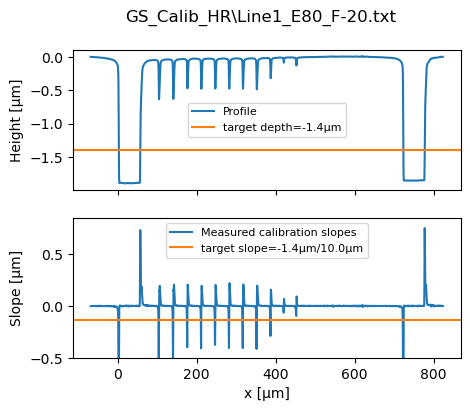

In [18]:
filename = 'GS_Calib_HR\\Line3_E80_F-20.txt'
filename = 'GS_Calib_HR\\Line2_E80_F-20.txt'
filename = 'GS_Calib_HR\\Line1_E80_F-20.txt'

target_depth_range = -1.4
target_lateral_range = 10
target_slope = target_depth_range/target_lateral_range


x,y = parse_profilometer_xy_data(filename)

x,y = align_profile_by_fiducials(x, y, distance_between_fiducial_centroids=720,  distance_fiducial_centroid_offset=-30, stylus_tip_offset=0)

y_slope = np.gradient(y,x)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(5,4))

plt.sca(ax[0])
plt.plot(x,y, label='Profile')

plt.axhline(target_depth_range, label='target depth=%0.1fµm'%(target_depth_range), c='C1')



plt.legend(fontsize=8)
plt.ylabel('Height [µm]')

plt.sca(ax[1])
plt.plot(x, y_slope, label='Measured calibration slopes')

plt.axhline(target_slope, label='target slope=%0.1fµm/%0.1fµm'%(target_depth_range,target_lateral_range), c='C1')

plt.legend(fontsize=8)
plt.ylabel('Slope [µm]')
plt.xlabel('x [µm]')
# plt.xlim(0,800)
plt.ylim(ymin = -0.5)
plt.suptitle(filename)


plt.savefig(filename.replace('.txt', '_slope.png'))

# Specific calibaration analysis


In [7]:
line3_step = np.array( [1,2,3,4,5,6,7,8,])
line2_step = np.array([9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
line1_step = np.array([   24,25,26,27,28,29,30,31,32,64,127,])

line_1_starting_position = np.array([100, 136, 172, 207, 242, 277, 312, 347, 382, 416, 448])
line_1_ending_position = line_1_starting_position + np.array([len(np.arange(0,128,i)) for i in line1_step])

line_2_starting_position = np.array([100, 145, 188, 230, 271, 311, 351, 390, 428,466, 504, 541, 570, 615, 651])
line_2_ending_position = line_2_starting_position + np.array([len(np.arange(0,128,i)) for i in line2_step])

line_3_starting_position = np.array([100, 258, 352, 425, 487, 543, 595,644])
line_3_ending_position = line_3_starting_position + np.array([len(np.arange(0,128,i)) for i in line3_step])

print(line_3_starting_position,line_3_ending_position, line_3_ending_position-line_3_starting_position,)

# start_gl = 0
# sublayers = np.arange(start_gl,128,i)


# line3_ending_position = 

[100 258 352 425 487 543 595 644] [228 322 395 457 513 565 614 660] [128  64  43  32  26  22  19  16]


Text(0.5, 0.98, 'GS_Calib_HR\\Line3_E80_F-20.txt')

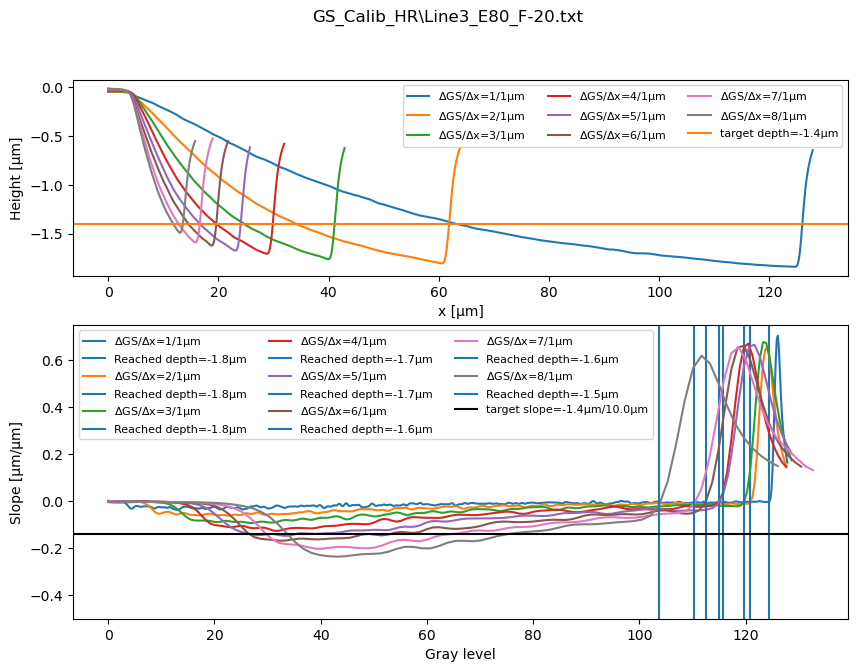

In [14]:
filename = 'GS_Calib_HR\\Line3_E80_F-20.txt'
line_starting_position, line_ending_position, line_step = line_3_starting_position, line_3_ending_position, line3_step

# filename = 'GS_Calib_HR\\Line2_E80_F-20.txt'
# line_starting_position, line_ending_position, line_step = line_2_starting_position, line_2_ending_position, line2_step

# filename = 'GS_Calib_HR\\Line1_E80_F-20.txt'
# line_starting_position, line_ending_position, line_step = line_1_starting_position, line_1_ending_position, line1_step


target_depth_range = -1.4
target_lateral_range = 10
target_slope = target_depth_range/target_lateral_range



x,y = parse_profilometer_xy_data(filename)

x,y = align_profile_by_fiducials(x, y, distance_between_fiducial_centroids=720,  distance_fiducial_centroid_offset=-30, stylus_tip_offset=0)

y_slope = np.gradient(y,x)

fig, ax = plt.subplots(2,1, sharex=False, figsize=(10,7), height_ratios=[2,3])

for start_x, end_x, step in zip(line_starting_position, line_ending_position, line_step):
    y1 = y[(x>=start_x) & (x<=end_x)]
    x1 = x[(x>=start_x) & (x<=end_x)]
    y1_slope = y_slope[(x>=start_x) & (x<=end_x)]

    y1 = np.array(y1)
    x1 = np.array(x1)
    y1_slope = np.array(y1_slope)
    x1 -= x1.min()
    GS_x = x1*step


    idx_max_depth = np.argmin(y1)

    max_depth = y1[idx_max_depth]
    max_depth_GS = GS_x[idx_max_depth]
    
    plt.sca(ax[0])
    # plt.plot(x1,y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
    # plt.plot(GS_x,y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
    plt.plot(x1,y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
    plt.sca(ax[1])
    # plt.plot(x1, y1_slope, label='$\Delta$GS/$\Delta$x=%dµm/step'%(step))
    plt.plot(GS_x, y1_slope, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
    # plt.plot(GS_x, y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))

    plt.axvline(max_depth_GS, label='Reached depth=%0.1fµm'%(max_depth))


plt.sca(ax[0])


plt.axhline(target_depth_range, label='target depth=%0.1fµm'%(target_depth_range), c='C1')



plt.legend(ncol=3, fontsize=8)
plt.ylabel('Height [µm]')
plt.xlabel('x [µm]')

plt.sca(ax[1])
# plt.plot(x, y_slope, label='Measured calibration slopes')

plt.axhline(target_slope, label='target slope=%0.1fµm/%0.1fµm'%(target_depth_range,target_lateral_range), c='k')

plt.legend(ncol=3, fontsize=8)
plt.ylabel('Slope [µm/µm]')
plt.xlabel('Gray level')
# plt.xlim(625,675)
plt.ylim(ymin = -0.5)
plt.suptitle(filename)


# plt.savefig(filename.replace('.txt', '_slope.png'))

## analysis of multiple lines


130
5 -1.6732400000000003 115.69469455603297
110
6 -1.622 112.5031167751763
96
7 -1.5880500000000002 110.30890705083755
80
8 -1.49094 103.72627787782221
76
9 -1.5324 105.94984065401147
65
10 -1.40941 99.76444506027462


Text(0.5, 0.98, 'GS_Calib_HR\\Line1_E80_F-20.txt')

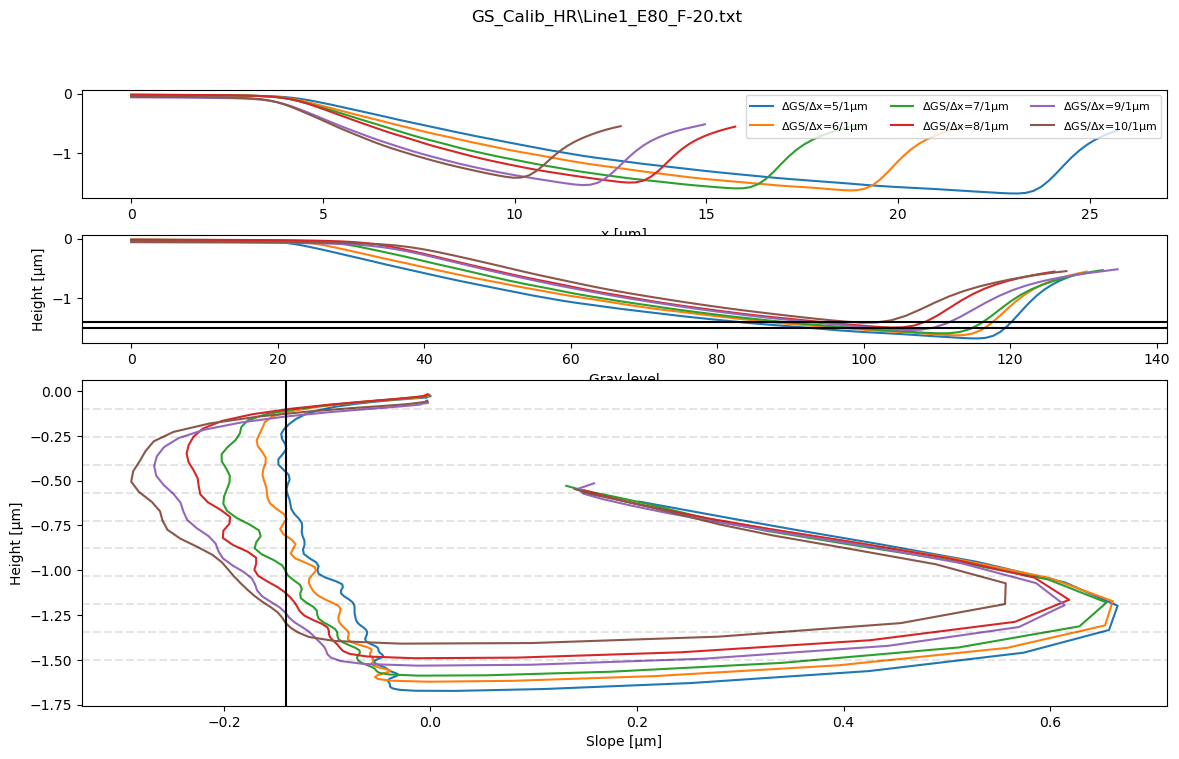

In [189]:
filename = 'GS_Calib_HR\\Line3_E80_F-20.txt'
line_starting_position, line_ending_position, line_step = line_3_starting_position, line_3_ending_position, line3_step

# filename = 'GS_Calib_HR\\Line2_E80_F-20.txt'
# line_starting_position, line_ending_position, line_step = line_2_starting_position, line_2_ending_position, line2_step

# filename = 'GS_Calib_HR\\Line1_E80_F-20.txt'
# line_starting_position, line_ending_position, line_step = line_1_starting_position, line_1_ending_position, line1_step


target_depth_range = -1.4
target_lateral_range = 10
target_slope = target_depth_range/target_lateral_range

fig, ax = plt.subplots(3,1, sharex=False, figsize=(14,8), height_ratios=[1,1,3])


# list_
# Sets the number of points to interp each of the profiles to
N_points_interp = 256
gs_interp = np.linspace(0,128,N_points_interp)


list_y1 = []
list_y1_slope = []
list_steps = []

for (filename, line_starting_position, line_ending_position, line_step)  in [('GS_Calib_HR\\Line3_E80_F-20.txt',line_3_starting_position, line_3_ending_position, line3_step),
                                                                    ('GS_Calib_HR\\Line2_E80_F-20.txt',line_2_starting_position, line_2_ending_position, line2_step),
                                                                    ('GS_Calib_HR\\Line1_E80_F-20.txt',line_1_starting_position, line_1_ending_position, line1_step)]:
    x,y = parse_profilometer_xy_data(filename)

    x,y = align_profile_by_fiducials(x, y, distance_between_fiducial_centroids=720,  distance_fiducial_centroid_offset=-30, stylus_tip_offset=0)

    y_slope = np.gradient(y,x)


    for start_x, end_x, step in zip(line_starting_position, line_ending_position, line_step):
        y1 = y[(x>=start_x) & (x<=end_x)]
        x1 = x[(x>=start_x) & (x<=end_x)]
        y1_slope = y_slope[(x>=start_x) & (x<=end_x)]

        y1 = np.array(y1)
        x1 = np.array(x1)
        y1_slope = np.array(y1_slope)



        x1 -= x1.min()
        GS_x = x1*step
        

        idx_max_depth = np.argmin(y1)

        max_depth = y1[idx_max_depth]
        max_depth_GS = GS_x[idx_max_depth]

        
        y1_interp = np.interp(gs_interp, GS_x, y1)
        y1_slope_interp = np.interp(gs_interp, GS_x, y1_slope)


        # Discard outside specs

        if max_depth > target_depth_range:
            continue
        
        if np.min(y1_slope) > target_slope:
            continue
        

        list_y1.append(y1_interp)
        list_y1_slope.append(y1_slope_interp)
        list_steps.append(step)
        
        print(len(y1))
        plt.sca(ax[0])
        plt.plot(x1,y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
        plt.sca(ax[1])
        # plt.plot(x1,y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
        plt.plot(GS_x,y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
        plt.sca(ax[2])
        # plt.plot(x1, y1_slope, label='$\Delta$GS/$\Delta$x=%dµm/step'%(step))
        # plt.plot(GS_x, y1_slope, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
        plt.plot(y1_slope, y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))
        # plt.plot(GS_x, y1, label='$\Delta$GS/$\Delta$x=%d/1µm'%(step))

        # plt.axvline(max_depth_GS, label='Reached depth=%0.1fµm'%(max_depth))
        print(step, max_depth, max_depth_GS)
plt.sca(ax[0])

plt.xlabel('x [µm]')
plt.legend(ncol=3, fontsize=8)
plt.sca(ax[1])


plt.axhline(target_depth_range, label='target depth=%0.1fµm'%(target_depth_range), c='k')
plt.axhline(-1.5, label='target depth=%0.1fµm'%(-1.5), c='k')



# plt.legend(ncol=3, fontsize=8)
plt.ylabel('Height [µm]')
plt.xlabel('Gray level')

plt.sca(ax[2])
# plt.plot(x, y_slope, label='Measured calibration slopes')

plt.axvline(target_slope, label='target slope=%0.1fµm/%0.1fµm'%(target_depth_range,target_lateral_range), c='k')


for height in np.linspace(-0.1, -1.5, 10):
    plt.axhline(height, c='k', ls='--', alpha=0.1)

# plt.legend(ncol=3, fontsize=8)
plt.xlabel('Slope [µm]')
plt.ylabel('Height [µm]')
# plt.xlim(625,675)
# plt.ylim(ymin = -0.5)
plt.suptitle(filename)


# plt.savefig(filename.replace('.txt', '_slope.png'))

7
9
10
9
7
7
6
6
5
5
[34, 39, 44, 50, 56, 63, 70, 79, 89, 98, 105]


(array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,  7,  9,  9,  9,  7,  7,
         5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  8,
         9,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,
         6, 

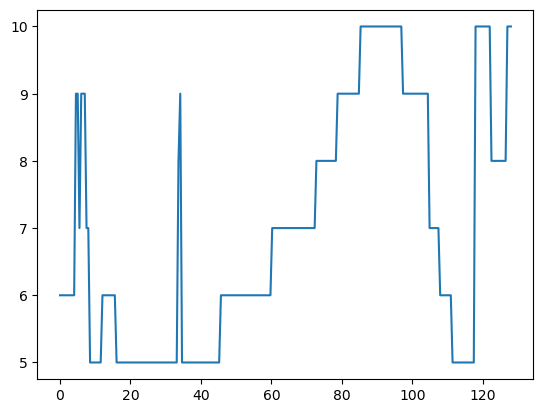

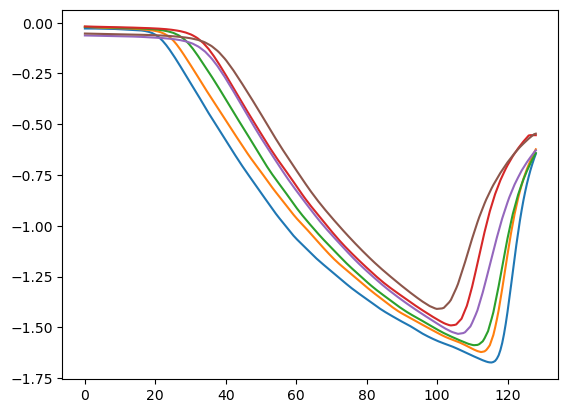

In [198]:
# Finding the closest values of the slope that are closest to the target slope, on any of the selections
# and extracts the steps and the y1 values for those


list_y1_slope = np.array(list_y1_slope)
list_y1 = np.array(list_y1)
list_steps = np.array(list_steps)
diff_slope = list_y1_slope-target_slope

idx = np.argmin(np.abs(diff_slope),axis=0)
slope_steps = list_steps[idx]
len(list_y1_slope),diff_slope

deepest_greylevel = 105

N_levels = 10

mask_levels = list()
mask_levels.append(deepest_greylevel)
for i in range(N_levels):
    delta_step = slope_steps[np.argmin(np.abs(gs_interp-mask_levels[i]))]
    print(delta_step)
    mask_levels.append(mask_levels[i]-delta_step)

mask_levels = list(reversed(mask_levels))
print(mask_levels)


plt.plot(gs_interp, list_steps[idx])


plt.figure()

for i in range(len(list_y1)):
    plt.plot(gs_interp, list_y1[i], label='step=%d'%list_steps[i])
# plt.plot(gs_interp, list_steps[idx])
# plt.plot(gs_interp, list_y1[idx])

list_steps[idx], len(idx)


In [147]:
import numpy as np

# 2D array
array_2d = np.array([[1, 2, 3],
                     [4, 5, 6],
                     [7, 8, 9]])

# 1D vector
vector = np.array([1,5,9])

# Calculate the Euclidean distance between each row of the 2D array and the vector
distances = np.linalg.norm(array_2d - vector, axis=(0,1))

# Find the index of the row with the minimum distance
index = np.argmin(distances,)

print("Index of the row closest to the vector:", index)
distances

Index of the row closest to the vector: 0


10.392304845413264

In [153]:
diff = array_2d-vector
diff,np.argmin(np.abs(diff),axis=0)

(array([[ 0, -3, -6],
        [ 3,  0, -3],
        [ 6,  3,  0]]),
 array([0, 1, 2], dtype=int64))

In [109]:
for a,b in ([[1,2],[3,4]]):
    print(a,b)

1 2
3 4


numpy.ndarray

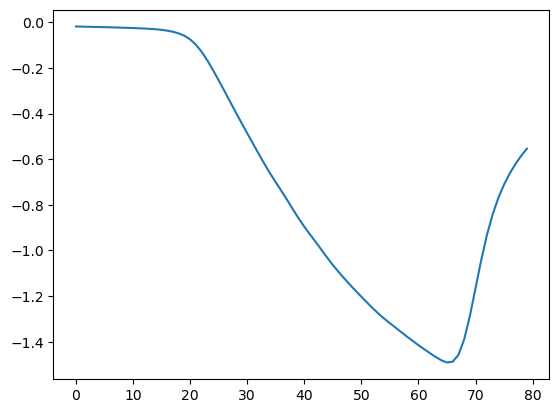

In [82]:
idx_max_depth
idx = np.argmin(y1)
y1.shape, y1

plt.plot(y1)
3
type(y1)